<a href="https://colab.research.google.com/github/aadityadamle/Copy-of-Toxic-Content-Detector-/blob/master/AD_Copy_of_ToxicContentDetector_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Slang Using BERT

### Installing Hugging Face library

In [1]:
!pip install transformers


     |████████████████████████████████| 778kB 3.3MB/s 
     |████████████████████████████████| 3.0MB 15.2MB/s 
     |████████████████████████████████| 890kB 32.7MB/s 
     |████████████████████████████████| 1.1MB 42.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=d420ccc8b675be9f5f776b26baa854515bc8353d209be752a138b6b4509cadc2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master()) #tpu.master() returns the grpc path (grpc://1.2.3.4:8470) of first instance
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu) #Connects to the given cluster using experimental module in config API
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()
#print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.125.25.162:8470


# Downloading data


In [4]:
!wget http://abcom.com/public-data/tutorials/ml-toxic/jigsawdata.zip

--2020-07-23 06:16:35--  http://abcom.com/public-data/tutorials/ml-toxic/jigsawdata.zip
Resolving abcom.com (abcom.com)... 104.24.103.18, 172.67.220.7, 104.24.102.18, ...
Connecting to abcom.com (abcom.com)|104.24.103.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51915053 (50M) [application/zip]
Saving to: ‘jigsawdata.zip’

jigsawdata.zip      100%[===================>]  49.51M  9.42MB/s    in 6.3s    

2020-07-23 06:16:42 (7.90 MB/s) - ‘jigsawdata.zip’ saved [51915053/51915053]



In [5]:
!unzip '/content/jigsawdata.zip'

Archive:  /content/jigsawdata.zip
   creating: bert toxix/
  inflating: bert toxix/test.csv     
  inflating: bert toxix/train.csv    


In [6]:
train = pd.read_csv("/content/bert toxix/train.csv")
test = pd.read_csv('/content/bert toxix/test.csv')


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Examining data

In [8]:
train[train['toxic']==1] #selecting and showing only those records which are toxic 


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


### Target distribution

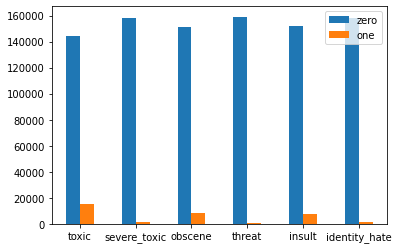

In [9]:
columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
zeros =[]
ones =[]
for col in columns:
  zeros.append(train[col].value_counts()[0]) #adds number of zeros in each column to the list zeros
  ones.append(train[col].value_counts()[1])  #adds number of zeros in each column to the list ones
  
  
df = pd.DataFrame({'zero': zeros,'one': ones}, index=columns)
df.plot.bar(rot=0)

# Build the model
Instantiating TFAutoModel, AutoConfig and AutoTokenizer will directly create a class of the relevant BERT architecture 

In [10]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.35)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

# Data preprocessing

### Tokenizing

In [11]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')  # bert is used for creating tokens for various types of models  

# Save the loaded tokenizer locally
save_path = 'distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

### Encoding

In [12]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist() #converting string texts in to word list of size = chunk_size
        encs = tokenizer.encode_batch(text_chunk) #list text_chunk is encoded and saved in list encs
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [13]:
# encoding the comments_text column for tarin and test data 
x = fast_encode(train.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_test = fast_encode(test.comment_text.astype(str), fast_tokenizer, maxlen=512)
y = train.toxic.values





Preparing datasets



In [15]:
BATCH_SIZE=64

train_dataset = (
    tf.data.Dataset  # create dataset
      .from_tensor_slices((x, y))  
      .repeat()
      .shuffle(2048)
      .batch(BATCH_SIZE)
    # AUTOTUNE prompts the runtime to prepare the next set 
    # while processing the current one
    .prefetch(tf.data.experimental.AUTOTUNE) 
)

 


test_data = (
    tf.data.Dataset# create dataset
    .from_tensor_slices(x_test) 
    .batch(BATCH_SIZE)
)

# focal losss

This is a new loss function created specifically to deal with the data imbalance problem for one-staged detectors. It improves the training with the imbalanced data created by the grid cells. It reshapes the cross entropy loss in such a way that it down weighs the loss assigned to well classified examples. This is so because the number of examples with backgrounds is too high and the classifier will almost always classify the background correctly.


Focal loss down weighs the easy examples and lays emphasis on the hard negative examples. It adds a modulating factor (1 − pt)^γ. By using the predicted probability ‘pt’, the loss function is able to deal with the hard and easy examples which the augmented cross entropy was unable to. Focal Loss is defined as


![alt text](https://miro.medium.com/max/439/1*gO_nxGFmpAelOrU_D9O5-Q.png)

‘γ’ is called the focusing parameter. It is tunable and can be learned by the model in a same way as hyper parameters. The purpose of the focusing parameter is to lessen the contribution of the easy examples. It does so in the following ways:
When an example is misclassified and ‘pt’ is small, then ‘γ’ nears 1 and the loss is unaffected
As ‘pt’ approaches 1, the modulating factor (1 − pt)^γ approaches 0 and the loss of the well classified examples is down weighted
‘γ’ smoothly adjusts the rate at which the easy examples are down-weighted. For example, when ‘γ’ = 0 then focal loss becomes normal cross entropy loss

In [17]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
      # defining probabilities  
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred)) 
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        #Expression of the focal loss is used and difference is calculated using the probabilities 
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))  
    return focal_loss_fixed
    

# initiate model

In [18]:
with strategy.scope():
    transformer_layer = transformers.TFBertModel.from_pretrained('bert-base-uncased')
    model = build_model(transformer_layer, loss=focal_loss(gamma=1.5), max_len=512)
model.summary()

- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 512, 768), (None, 109482240 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


# training 

In [19]:
with strategy.scope():
  train_history = model.fit(
      train_dataset,
      
      steps_per_epoch=150,
      
      epochs=10
  )

Epoch 1/10
150/150 [==============================] - 43s 286ms/step - auc: 0.7456 - loss: 0.0352
Epoch 2/10
150/150 [==============================] - 43s 286ms/step - auc: 0.9623 - loss: 0.0158
Epoch 3/10
150/150 [==============================] - 43s 286ms/step - auc: 0.9684 - loss: 0.0141
Epoch 4/10
150/150 [==============================] - 43s 286ms/step - auc: 0.9754 - loss: 0.0130
Epoch 5/10
150/150 [==============================] - 43s 287ms/step - auc: 0.9757 - loss: 0.0127
Epoch 6/10
150/150 [==============================] - 43s 286ms/step - auc: 0.9760 - loss: 0.0131
Epoch 7/10
150/150 [==============================] - 43s 287ms/step - auc: 0.9765 - loss: 0.0124
Epoch 8/10
150/150 [==============================] - 43s 288ms/step - auc: 0.9817 - loss: 0.0117
Epoch 9/10
150/150 [==============================] - 43s 288ms/step - auc: 0.9800 - loss: 0.0117
Epoch 10/10
150/150 [==============================] - 43s 287ms/step - auc: 0.9824 - loss: 0.0110


# Predicting on test set

In [20]:
test['toxic'] = model.predict(test_data, verbose=1)

2394/2394 [==============================] - 218s 91ms/step


Save it to CSV and load it 

In [21]:
test.to_csv('test.csv', index=False)
data=pd.read_csv('/content/test.csv')
data.head()

,id,comment_text,toxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.831462
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.036266
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.035200
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.011134
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.043799


In [22]:
def replace(toxic):
  if toxic >=0.5:
    toxic=1
  else:
    toxic=0
  return toxic


test['prediction']=test['toxic'].apply(lambda x : replace(x))

In [23]:
test.head()

,id,comment_text,toxic,prediction
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.831462,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.036266,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.035200,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.011134,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.043799,0


Text(0, 0.5, 'count')

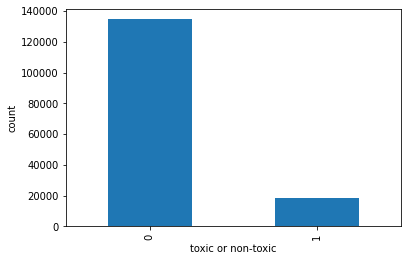

In [24]:
import matplotlib.pyplot as plt
test.prediction.value_counts().plot(kind='bar')
plt.xlabel('toxic or non-toxic')
plt.ylabel('count')

In [25]:
#Selecting arbitary examples from the datset 
text1=test.comment_text[186]
text1

'Are you also suggesting all paintings of black moors are fake too? are you saying that they should be white?'

In [26]:
text2=test.comment_text[225]
text2

'Thanks for experimenting with Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.     (comment moved from user page by  )'

In [27]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    #for i in tqdm(range(0, len(texts), chunk_size)):
    #text_chunk = texts[i:i+chunk_size].tolist()
    encs = tokenizer.encode_batch(texts)
    all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [28]:
def pred(pred):
  if pred >= 0.5:
    p=1
  else:
    p=0
  return p

In [29]:
p1=fast_encode([text1], fast_tokenizer, maxlen=512)
p1 = model.predict(p1)
pred(p1)

0

In [30]:
p2=fast_encode([text2], fast_tokenizer, maxlen=512)
p2=model.predict(p2)
pred(p2)

0

In [31]:
# Using our own example
text3 =["Every once in a while, I get the urge. You know what I'm talking about, don't you? The urge for destruction. The urge to hurt, maim, kill. It's quite a thing to experience that urge, to let it wash over you, to give in to it. It's addictive. It's all-consuming. You lose yourself to it. It's quite, quite wonderful. I can feel it, even as I speak, tapping around the edges of my mind, trying to prise me open, slip its fingers in. And it would be so easy to let it happen. But we're all like that, aren't we? We're all barbarians at our core. We're all savage, murderous beasts. I know I am. I'm sure you are. The only difference between us, Mr. Prave, is how loudly we roar. I know I roar very loudly indeed. How about you. Do you think you can match me"]

In [32]:
text3

["Every once in a while, I get the urge. You know what I'm talking about, don't you? The urge for destruction. The urge to hurt, maim, kill. It's quite a thing to experience that urge, to let it wash over you, to give in to it. It's addictive. It's all-consuming. You lose yourself to it. It's quite, quite wonderful. I can feel it, even as I speak, tapping around the edges of my mind, trying to prise me open, slip its fingers in. And it would be so easy to let it happen. But we're all like that, aren't we? We're all barbarians at our core. We're all savage, murderous beasts. I know I am. I'm sure you are. The only difference between us, Mr. Prave, is how loudly we roar. I know I roar very loudly indeed. How about you. Do you think you can match me"]

In [33]:
p3=fast_encode(text3, fast_tokenizer, maxlen=512)
p3=model.predict(p3)
pred(p3)

0